In [ ]:
import os
%pylab inline
from skimage.io import imread
from skimage import exposure
from skimage.transform import resize
from skimage.exposure import adjust_gamma
import numpy as np
import tensorflow as tf
from skimage.measure import label, regionprops
import numpy as np
import sys
from scipy.stats import mode
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.stats import mode

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Data augmentation for batches
class Data_Augmentation():
    def __init__(self, batch_size, validation_size, directory, train_test='train'):
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.directory = directory

        nPerSet = {'train': 85, 'testA': 60, 'testB': 20}
        self.image_files = [os.path.join(self.directory, f'{train_test}_{i}.bmp') for i in range(1, nPerSet[train_test]+1)]
        self.annotation_files = [os.path.join(self.directory, f'{train_test}_{i}_anno.bmp') for i in range(1, nPerSet[train_test]+1)]

        # load images
        self.full_images = [imread(f)/255 for f in self.image_files]
        self.full_annotations = [imread(f) for f in self.annotation_files]

        # Train-valid split
        self.idxs = np.arange(len(self.image_files))
        np.random.seed(1)
        np.random.shuffle(self.idxs)
        self.val_idxs = self.idxs[:self.validation_size]
        self.train_idxs = self.idxs[self.validation_size:]

    @staticmethod # Data Augmentation
    def _augment(batch_x, batch_y):
        # vertical and horizontal symmetry
        if( np.random.random()<0.5 ):
            batch_x = batch_x[:,::-1,:,:]
            batch_y = batch_y[:,::-1,:]
        if( np.random.random()<0.5 ):
            batch_x = batch_x[:,:,::-1,:]
            batch_y = batch_y[:,:,::-1]
        # Gamma
        gamma = (np.random.random()-0.5)*2
        if gamma < 0:
            gamma=1/(1-gamma)
        else:
            gamma=1+gamma
        batch_x_ = batch_x.copy()
        for i in range(len(batch_x)):
            batch_x_[i] = adjust_gamma(batch_x[i], gamma=gamma)
        # Random noise
        batch_x_ += np.random.normal(0, 0.02, size=batch_x.shape)
        return batch_x_,batch_y

In [ ]:
class imageGeneration(Data_Augmentation):
    # read train and valid sets
    def __init__(self, batch_size, validation_size, directory, image_size, train_test='train', **kwargs):
        super().__init__(batch_size, validation_size, directory, train_test)

        self.image_size = image_size
        self.batches_per_epoch = len(self.train_idxs)//self.batch_size

        self.val_x = np.array([self.preprocess_image(self.full_images[idx]) for idx in self.val_idxs])
        self.val_y = np.array([self.preprocess_anno(self.full_annotations[idx]) for idx in self.val_idxs])

        self.train_x = np.array([self.preprocess_image(self.full_images[idx]) for idx in self.train_idxs])
        self.train_y = np.array([self.preprocess_anno(self.full_annotations[idx]) for idx in self.train_idxs])

    # Random shuffle of images
    def next_batch(self, n_epochs):
        for e in range(n_epochs):
            np.random.shuffle(self.train_idxs)
            for i in range(self.batches_per_epoch):
                batch_x = self.train_x[i*self.batch_size:(i+1)*self.batch_size]
                batch_y = self.train_y[i*self.batch_size:(i+1)*self.batch_size]>0
                yield self._augment(batch_x,batch_y)
    def get_validation_data(self):
        return self.val_x, self.val_y>0

    def preprocess_image(self, im):
        return resize(im, self.image_size)

    def preprocess_anno(self, anno):
        return resize(anno, self.image_size, preserve_range=True, order=0, anti_aliasing=False) 

In [ ]:
# Model training / Optimization / Post-processing
class Model():
    def __init__(self, image_size, clf_name, loadFrom=None, lr=1e-4, eps=1e-8):
        self.image_size = image_size
        self.clf_name = clf_name
        if(loadFrom == None):
            self.set_model()
            opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=eps, name='Adam')
            self.model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.losses.SparseCategoricalCrossentropy(name='crossentropy'), 'accuracy'])
        else:
            self.model = tf.keras.models.load_model(loadFrom, compile=False, custom_objects={'leaky_relu': tf.nn.leaky_relu})

    def fit(self, n_epochs, dataset, patience=15):
        validation_data = None
        callbacks = []
        if(len(dataset.val_idxs) > 0):
            callbacks = [tf.keras.callbacks.ModelCheckpoint(f"{self.clf_name}.hdf5", save_best_only=True),tf.keras.callbacks.EarlyStopping(monitor='val_crossentropy', patience=patience)]
            validation_data = dataset.get_validation_data()

        return self.model.fit(dataset.next_batch(n_epochs), epochs=n_epochs, steps_per_epoch=dataset.batches_per_epoch, validation_data=validation_data, callbacks=callbacks)

    def predict(self, data):
        return self.model.predict(data)

    # post-processing
    @staticmethod
    def post_process(pred, min_area=400):
        pred_mask = np.argmax(pred, axis=2)
        # labeling
        lab = label(pred_mask)
        # remove small objects
        for obj in regionprops(lab):
            if( obj.area < min_area ):
                lab[lab==obj.label] = 0
            # hole filling
            else:
                region = lab[obj.bbox[0]:obj.bbox[2],obj.bbox[1]:obj.bbox[3]]
                region[obj.filled_image] = obj.label
        return lab

In [ ]:
class evaluation:

    @classmethod
    def evaluate(cls, model, data, train_val, overlap='minimum', min_area=40):

        metrics = []
        if train_val == 'train':
            data_x = [data.full_images[idx] for idx in data.train_idxs]
            data_y = [data.full_annotations[idx] for idx in data.train_idxs]
        elif train_val == 'val':
            data_x = [data.full_images[idx] for idx in data.val_idxs]
            data_y = [data.full_annotations[idx] for idx in data.val_idxs]

        # predict
        for im, anno in zip(data_x, data_y):
            im_ = data.preprocess_image(im)
            pred_image = resize(model.predict(np.array([im_]))[0], im.shape[:2])
            pred_labels = model.post_process(pred_image, min_area)
            metrics += [cls._get_metrics(anno, pred_labels)]
        return np.array(metrics)

    @staticmethod
    def _get_metrics(gt_labels, pred_labels):
        # remove pixels with area smaller than 5
        for i in range(1, gt_labels.max()+1):
            if( (gt_labels==i).sum() < 5 ):
                gt_labels[gt_labels==i] = 0

        trueLabels = np.unique(gt_labels)
        trueLabels = trueLabels[trueLabels>0].astype('int')
        predLabels = np.unique(pred_labels)
        predLabels = predLabels[predLabels>0].astype('int')

        best_matches = np.zeros((len(predLabels),3))
        best_matches[:,0] = predLabels
        for i in range(len(predLabels)):
            predObject = pred_labels==predLabels[i]
            corrRegionInGT = gt_labels[predObject]  
            if corrRegionInGT.max() > 0:
                bestMatch = mode(corrRegionInGT[corrRegionInGT>0])[0][0] 
                matchInGT = gt_labels==bestMatch   
                best_matches[i,1] = bestMatch       
                overlap = predObject*matchInGT 
                best_matches[i,2] = (overlap.sum()/matchInGT.sum())>0.2 # % of overlap 
        
        TP = int(best_matches[:,2].sum())
        FP = int((best_matches[:,2]==0).sum())
        FN = int(len(trueLabels)-TP)
        
        # precision & recall
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        
        gt_mask = gt_labels>0
        pred_mask = pred_labels>0
        TP = float(((gt_mask==True)*(pred_mask==True)).sum())
        FP = float(((gt_mask==False)*(pred_mask==True)).sum())
        FN = float(((gt_mask==True)*(pred_mask==False)).sum())
        TN = float(((gt_mask==False)*(pred_mask==False)).sum())
        # segmentation MCC
        MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        return precision, recall, MCC

In [ ]:
class Long_Model(Model):
    def __init__(self, image_size, clf_name, loadFrom=None, lr=1e-4, eps=1e-8):
        super().__init__(image_size, clf_name, loadFrom=loadFrom, lr=lr, eps=eps)

    def set_model(self):
        inputs = tf.keras.Input(shape=self.image_size+(3,))
        x = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.leaky_relu, padding='same')(inputs)
        A = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.leaky_relu, padding='same')(x)
        x_ = tf.keras.layers.MaxPool2D(2)(A)
        x = tf.keras.layers.Conv2D(64, 3, activation=tf.nn.leaky_relu, padding='same')(x_)
        x = tf.keras.layers.Conv2D(64, 3, activation=tf.nn.leaky_relu, padding='same')(x)
        B = tf.concat([x_, x], axis=3)
        x_ = tf.keras.layers.MaxPool2D(2)(B)
        x = tf.keras.layers.Conv2D(128, 3, activation=tf.nn.leaky_relu, padding='same')(x_)
        x = tf.keras.layers.Conv2D(128, 3, activation=tf.nn.leaky_relu, padding='same')(x)
        x = tf.concat([x_, x], axis=3)
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.concat([B, x], axis=3)
        x = tf.keras.layers.Conv2D(64, 3, activation=tf.nn.leaky_relu, padding='same')(x)
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.concat([A, x], axis=3)
        x = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.leaky_relu, padding='same')(x)
        outputs = tf.keras.layers.Conv2D(2, 1, activation=tf.nn.softmax)(x)

        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/100
15/15 [==============================] - 4s 224ms/step - loss: 0.6914 - crossentropy: 0.6914 - accuracy: 0.5309 - val_loss: 0.6981 - val_crossentropy: 0.6981 - val_accuracy: 0.4838
Epoch 2/100
15/15 [==============================] - 3s 216ms/step - loss: 0.6938 - crossentropy: 0.6938 - accuracy: 0.5062 - val_loss: 0.6897 - val_crossentropy: 0.6897 - val_accuracy: 0.5136
Epoch 3/100
15/15 [==============================] - 3s 211ms/step - loss: 0.6867 - crossentropy: 0.6867 - accuracy: 0.5604 - val_loss: 0.6867 - val_crossentropy: 0.6867 - val_accuracy: 0.5267
Epoch 4/100
15/15 [==============================] - 3s 216ms/step - loss: 0.6831 - crossentropy: 0.6831 - accuracy: 0.5755 - val_loss: 0.7009 - val_crossentropy: 0.7009 - val_accuracy: 0.5073
Epoch 5/100
15/15 [==============================] - 3s 214ms/step - loss: 0.6852 - crossentropy: 0.6852 - accuracy: 0.5560 - val_loss: 0.6900 - val_crossentropy: 0.6900 - val_accuracy: 0.5245
Epoch 6/100
15/15 [================

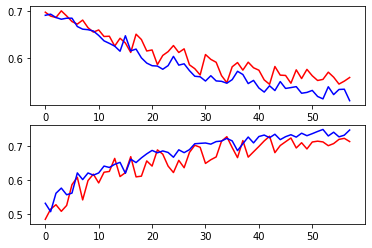

In [ ]:
# parameters
lr = 1e-3
eps = 1e-7
overlap = 'minimum'
max_epochs = 100
patience = 20
directory = "/content/drive/MyDrive/Spring 21/Spring Courses/COMP 548/Project/Warwick_Dataset/"
image_size = (256,384)
batch_size = 5
validation_size = 10
min_area = 40
clf_name = 'long_model_image'

tf.keras.backend.clear_session()

# Training
generator = imageGeneration(batch_size, validation_size, directory, image_size)
model = Long_Model((256,384),clf_name = 'long_model_image',loadFrom = None)
history = model.fit(max_epochs, generator, patience=patience)

# plots
plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['val_loss'], 'r-')
plt.plot(history.history['loss'], 'b-')
plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'], 'r-')
plt.plot(history.history['accuracy'], 'b-')
plt.savefig(f'{clf_name}_history.png')


train_metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)
val_metrics = evaluation.evaluate(model, generator, 'val', overlap, min_area)

with open(f"{clf_name}_metrics.txt", 'w') as fp:
    print("Training perfomance:", file=fp)
    print("Precision\tRecall\tMCC", file=fp)
    print(train_metrics.mean(axis=0), file=fp)
    print(np.median(train_metrics,axis=0), file=fp)
    print(" ---- ", file=fp)
    print("Validation perfomance:", file=fp)
    print("Precision\tRecall\tMCC", file=fp)
    print(val_metrics.mean(axis=0), file=fp)
    print(np.median(val_metrics,axis=0), file=fp)

np.save(f"{'long_model_image'}_metrics_train.npy", train_metrics)
np.save(f"{'long_model_image'}_metrics_val.npy", val_metrics)

Epoch 1/100
10/10 [==============================] - 8s 398ms/step - loss: 0.6974 - crossentropy: 0.6974 - accuracy: 0.5034 - val_loss: 0.6982 - val_crossentropy: 0.6982 - val_accuracy: 0.4500
Epoch 2/100
10/10 [==============================] - 2s 217ms/step - loss: 0.6921 - crossentropy: 0.6921 - accuracy: 0.5267 - val_loss: 0.6924 - val_crossentropy: 0.6924 - val_accuracy: 0.5050
Epoch 3/100
10/10 [==============================] - 2s 220ms/step - loss: 0.6890 - crossentropy: 0.6890 - accuracy: 0.5193 - val_loss: 0.6892 - val_crossentropy: 0.6892 - val_accuracy: 0.5698
Epoch 4/100
10/10 [==============================] - 2s 218ms/step - loss: 0.6839 - crossentropy: 0.6839 - accuracy: 0.5845 - val_loss: 0.6863 - val_crossentropy: 0.6863 - val_accuracy: 0.5770
Epoch 5/100
10/10 [==============================] - 2s 223ms/step - loss: 0.6799 - crossentropy: 0.6799 - accuracy: 0.5758 - val_loss: 0.6761 - val_crossentropy: 0.6761 - val_accuracy: 0.6573
Epoch 6/100
10/10 [================

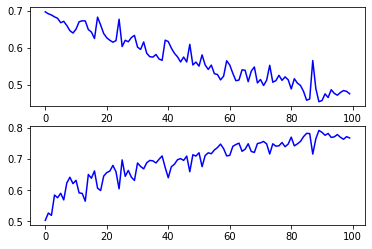

In [ ]:
# parameters
lr = 1e-3
eps = 1e-7
overlap = 'minimum'
max_epochs = 100
patience = 20
directory = "/content/drive/MyDrive/Spring 21/Spring Courses/COMP 548/Project/Warwick_Dataset/"
image_size = (256,384)
batch_size = 5
validation_size = 10
min_area = 40
clf_name = 'long_model_image'

tf.keras.backend.clear_session()

# model = Model(image_size, clf_name, loadFrom=f'{clf_name}.hdf5')
model = Long_Model((256,384),clf_name = 'long_model_image',loadFrom = None)

# Compute & save metrics
generator = imageGeneration(batch_size, validation_size, directory, image_size, train_test='testA')
metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)
history = model.fit(max_epochs, generator, patience=patience)

plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['loss'], 'b-')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], 'b-')
plt.savefig(f'{clf_name}_history.png')


with open(f"{clf_name}_testA_metrics.txt", 'w') as fp:
    print("Test A")
    print("Precision\tRecall\tMCC", file=fp)
    print(metrics.mean(axis=0), file=fp)
    print(np.median(metrics,axis=0), file=fp)
    
np.save(f"{clf_name}_testA_metrics.npy", metrics)

generator = imageGeneration(batch_size, validation_size, directory, image_size, train_test='testB')
metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)

with open(f"{clf_name}_testB_metrics.txt", 'w') as fp:
    print("Test B")
    print("Precision\tRecall\tMCC", file=fp)
    print(metrics.mean(axis=0), file=fp)
    print(np.median(metrics,axis=0), file=fp)
    
np.save(f"{clf_name}_testB_metrics.npy", metrics)
